# Introduction

This notebook uses multidimensional scaling (MDS) to visualize the Dice distances term and structure occurrences in documents. Documents are colored by their domain assignments in each framework.

# Load the data

In [1]:
import pandas as pd
import sys
sys.path.append("..")
import utilities, mds

## Brain activation coordinates

In [2]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Term occurrences

In [3]:
frameworks = ["data-driven", "data-driven", "rdoc", "dsm"]
list_suffixes = ["", "", "_opsim", "_opsim"]
circuit_suffixes = ["_lr", "_nn", "", ""]
lists, words = {}, []
for fw, list_suffix, circuit_suffix in zip(frameworks, list_suffixes, circuit_suffixes):
    lists[fw], _ = utilities.load_framework(fw, suffix=list_suffix, clf=circuit_suffix)
    words += list(lists[fw]["TOKEN"])

In [4]:
words = sorted(list(set(words)))
len(words)

281

In [5]:
dtm_bin = utilities.load_doc_term_matrix(version=190325, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Document dissimilarities

In [6]:
from scipy.spatial.distance import cdist

In [7]:
pmids = act_bin.index.intersection(dtm_bin.index)
len(pmids)

18155

In [8]:
act_bin = act_bin.loc[pmids]
dtm_bin = dtm_bin.loc[pmids]

In [9]:
vecs = act_bin.copy()
vecs[words] = dtm_bin[words]
vecs.shape

(18155, 399)

## Document splits

In [10]:
splits = {}
splits["discovery"] = [int(pmid.strip()) for pmid in open("../data/splits/train.txt")]
splits["replication"] = [int(pmid.strip()) for pmid in open("../data/splits/validation.txt")]
splits["replication"] += [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
for split, pmids in splits.items():
    print("{:12s} N={}".format(split.title(), len(pmids)))

Discovery    N=12708
Replication  N=5447


## Domain assignments

In [11]:
partitions = {fw + suffix: pd.read_csv("../partition/data/doc2dom_{}{}.csv".format(
                                     fw, suffix), index_col=0, header=None) 
              for fw, suffix in zip(frameworks, circuit_suffixes)}

# Fit the MDS model

In [12]:
import os
from sklearn.manifold import MDS

In [13]:
metric = True
eps = 0.001
max_iter = 5000

In [15]:
outfile = "data/mds_metric{}_eps{}_iter{}.csv".format(
              int(metric), eps, int(max_iter))
    
if not os.path.exists(outfile):

    print("----- Computing document distances")
    doc_dists = cdist(vecs, vecs, metric="dice")

    print("----- Fitting MDS model")
    mds_model = MDS(n_components=2, max_iter=max_iter, metric=metric, eps=eps,
                    dissimilarity="precomputed", random_state=42)
    X = mds_model.fit_transform(doc_dists)
    X_df = pd.DataFrame(X, index=split_pmids, columns=["X", "Y"])
    X_df.to_csv(outfile)

else:
    print("----- Loading MDS model")
    X = pd.read_csv(outfile, index_col=0, header=0).values

----- Loading MDS model


# Plot the results

In [16]:
from style import style
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
domain2order = {}
for framework in frameworks:
    domain2order[framework] = {}
    for domain in style.order[framework]:
        domain2order[framework][domain] = style.order[framework].index(domain)

In [18]:
colors = {}
for framework, suffix in zip(frameworks, circuit_suffixes):
    key = framework + suffix
    colors[key] = {}
    for split in splits:
        colors[key][split] = []
        for pmid in vecs.index:
            if pmid in splits[split]:
                domain = partitions[key].loc[pmid].values[0]
                idx = domain2order[framework][domain]
                colors[key][split].append(style.palettes[framework][idx])
            else:
                colors[key][split].append("none")

In [19]:
shapes = ["o", "v", "^", ">", "<", "s", "X", "D", "p"]

In [20]:
markers = {}
for framework, suffix in zip(frameworks, circuit_suffixes):
    key = framework + suffix
    markers[key] = []
    for pmid in vecs.index:
        domain = partitions[key].loc[pmid].values[0]
        idx = domain2order[framework][domain]
        markers[key].append(shapes[idx])

## Data-driven

Plotting discovery set


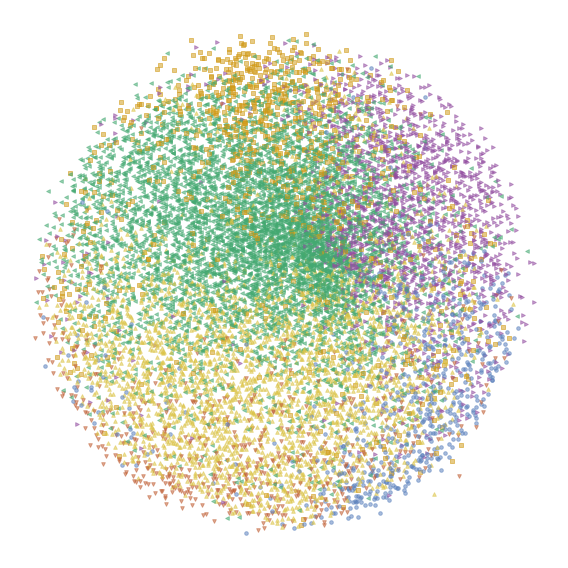

Plotting replication set


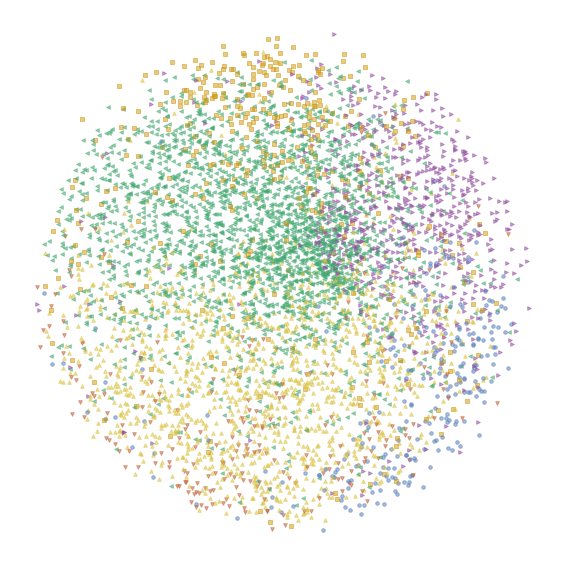

In [21]:
for split in splits.keys():
    print("Plotting {} set".format(split))
    mds.plot_mds(X, "data-driven", split, colors, markers, metric, eps, max_iter, suffix="_lr")

Plotting discovery set


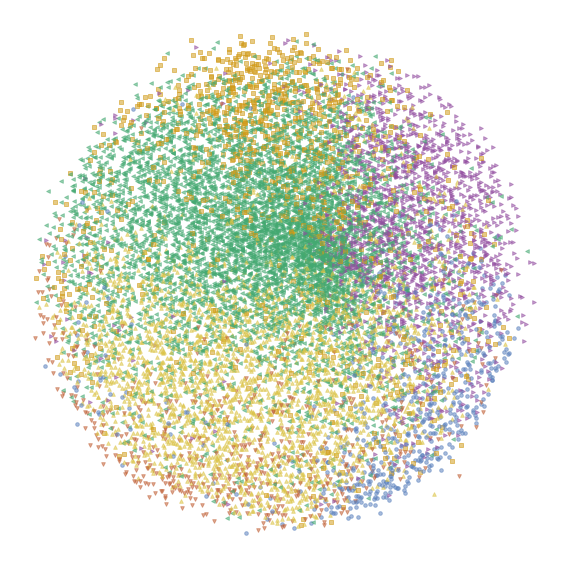

Plotting replication set


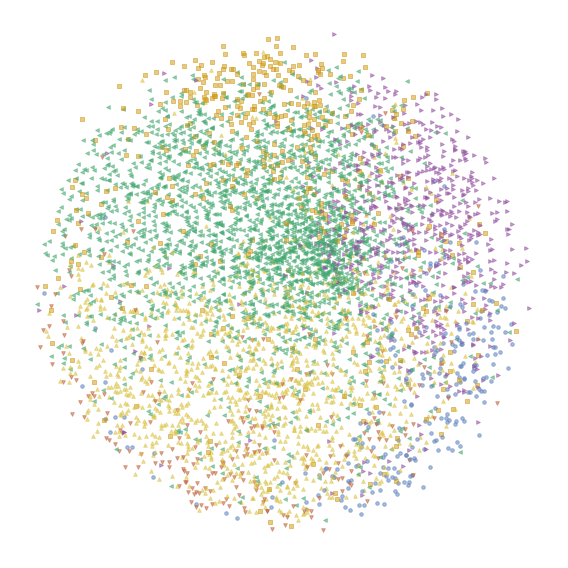

In [22]:
for split in splits.keys():
    print("Plotting {} set".format(split))
    mds.plot_mds(X, "data-driven", split, colors, markers, metric, eps, max_iter, suffix="_nn")

## RDoC

Plotting discovery set


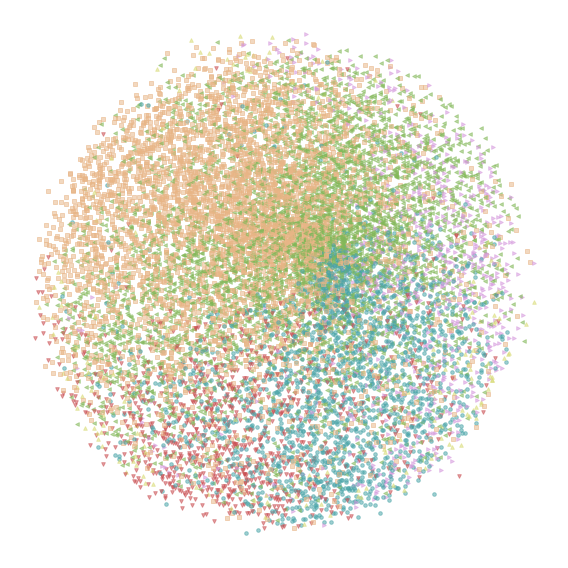

Plotting replication set


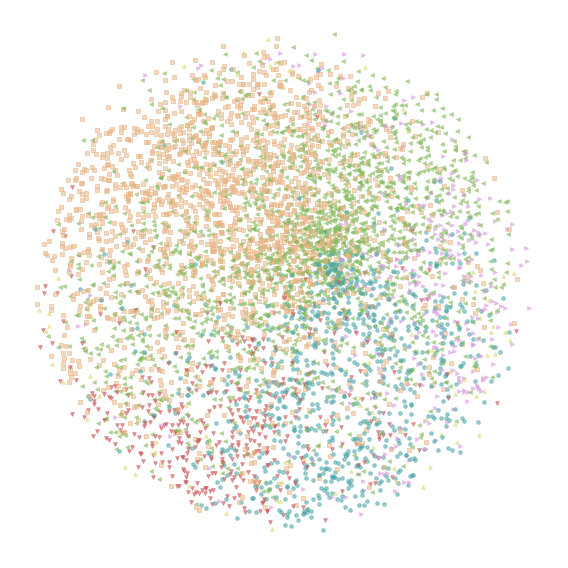

In [23]:
for split in splits.keys():
    print("Plotting {} set".format(split))
    mds.plot_mds(X, "rdoc", split, colors, markers, metric, eps, max_iter)

## DSM

Plotting discovery set


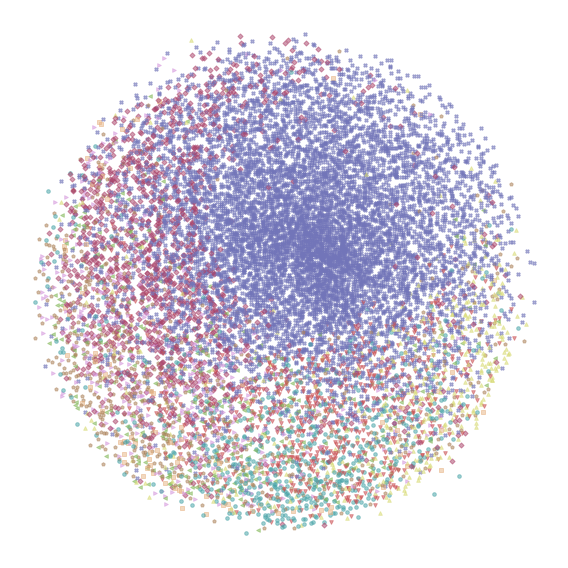

Plotting replication set


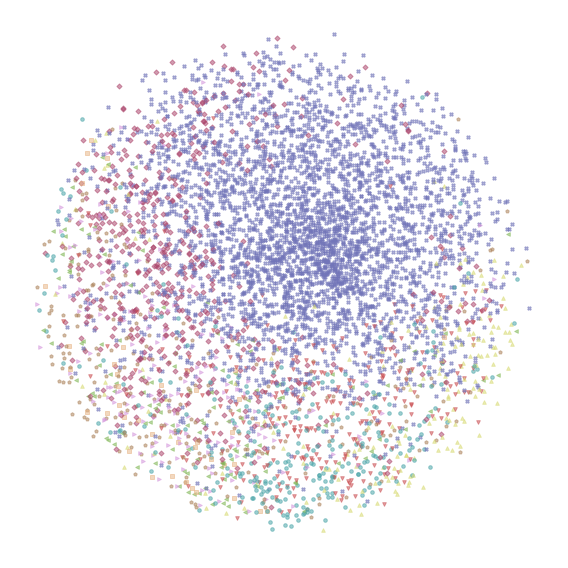

In [24]:
for split in splits.keys():
    print("Plotting {} set".format(split))
    mds.plot_mds(X, "dsm", split, colors, markers, metric, eps, max_iter)